In [684]:
NUMBER_OF_EPOCH = 5000
# num_of_categories = 

In [685]:
import torch
import torch.nn as nn
import pandas as pd
import math
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.backends.cuda.is_built():
    mps_device = torch.device("cuda")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='cuda:0')


In [686]:
def prepare_model(df):
    
    # df = pre.standardize(df)
    # df = pre.encoder(df)
    # df = df.drop(['id'], axis=1)

    from sklearn.model_selection import train_test_split
    train, val = train_test_split(df, test_size=0.10)

    y_train = torch.tensor(train['price'].values, dtype=torch.float32)
    X_train = train.drop(['price'], axis=1)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)

    y_val = torch.tensor(val['price'].values, dtype=torch.float32)
    X_val = val.drop(['price'], axis=1)
    X_val = torch.tensor(X_val.values, dtype=torch.float32)
        
    return X_train, y_train, X_val, y_val

In [687]:
# Define model
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        
        self.layers = nn.Sequential(
        nn.Linear(8, 1024),
        nn.ReLU(), 

        nn.Linear(1024, 64),
        nn.ReLU(), 
        
        nn.Linear(64, 32),
        nn.ReLU(),
        
        nn.Linear(32, 4),
        nn.ReLU(),
        
        nn.Linear(4, 1)
        )
        
        self.model_layer = nn.Sequential(
        nn.Linear(164, 1),
        nn.ReLU()
        )
        
        self.gear_box_layer = nn.Sequential(
        nn.Linear(3, 1),
        nn.ReLU()
        )
        
        self.fuel_type_layer = nn.Sequential( 
        nn.Linear(4, 1),
        nn.ReLU()
        )
        
    def forward(self, x):
        # print(x.shape)
        model = self.model_layer(x[:, 5:169])
        gear_box = self.gear_box_layer(x[:, 169:172])
        fuel_type = self.fuel_type_layer(x[:, 172:176])
        
        # registration_fee = self.registration_fee_layer(x[:, 156:164])
        # engine_capacity = self.engine_capacity_layer(x[:, 164:174])
        # operating_hours = x[:, 174].view(-1, 1)
        # year = x[:, 175].view(-1, 1)
        # efficiency = x[:, 176].view(-1, 1)

        
        # x = torch.cat((model, year, gear_box, operating_hours, fuel_type, registration_fee, efficiency, engine_capacity), 1)
        
        x = torch.cat((model, gear_box, fuel_type, x[:, :5]), 1)
        
        return self.layers(x)

model = mlp()
model

mlp(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
  )
  (model_layer): Sequential(
    (0): Linear(in_features=164, out_features=1, bias=True)
    (1): ReLU()
  )
  (gear_box_layer): Sequential(
    (0): Linear(in_features=3, out_features=1, bias=True)
    (1): ReLU()
  )
  (fuel_type_layer): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
    (1): ReLU()
  )
)

In [688]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [689]:
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [690]:
df = pd.read_csv('data/train.csv')
X_train, y_train, X_val, y_val = prepare_model(df)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([8910, 176]) torch.Size([8910]) torch.Size([990, 176]) torch.Size([990])


In [691]:
import numpy as np 
best_val_loss = float('inf')
training_loss = np.array([])
validation_loss = np.array([])
last_val_loss = float('inf')
count = 0


for n in range(NUMBER_OF_EPOCH):
    model.train()
    y_pred = model(X_train)[:, 0]
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    y_pred = model(X_val)[:, 0]
    val_loss = loss_fn(y_pred, y_val).item()
    validation_loss = np.append(validation_loss, val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'mlp_model.pth')
        
    y_pred = model(X_train)[:, 0]
    training_loss_eval = loss_fn(y_pred, y_train).item()
    training_loss = np.append(training_loss, training_loss_eval)
    
    if n % 100 == 0:
        print(f'Epoch: {n} Training loss:  {training_loss_eval}'f' Validation loss: {val_loss}'f' best Validation loss: {best_val_loss}')
        
    if last_val_loss < val_loss:
        count += 1
        if count == 25:
            break
    else:
        count = 0
    last_val_loss = val_loss

Epoch: 0 Training loss:  19161.673828125 Validation loss: 18670.85546875 best Validation loss: 18670.85546875
Epoch: 100 Training loss:  18203.875 Validation loss: 17722.126953125 best Validation loss: 17722.126953125
Epoch: 200 Training loss:  5437.90771484375 Validation loss: 4707.96337890625 best Validation loss: 4707.96337890625
Epoch: 300 Training loss:  4312.248046875 Validation loss: 3629.704833984375 best Validation loss: 3629.704833984375
Epoch: 400 Training loss:  3688.150634765625 Validation loss: 3010.062744140625 best Validation loss: 3010.062744140625
Epoch: 500 Training loss:  3214.71728515625 Validation loss: 2601.906982421875 best Validation loss: 2601.906982421875
Epoch: 600 Training loss:  2853.19677734375 Validation loss: 2336.723876953125 best Validation loss: 2336.723876953125
Epoch: 700 Training loss:  2680.368408203125 Validation loss: 2208.45654296875 best Validation loss: 2208.45654296875
Epoch: 800 Training loss:  2589.994140625 Validation loss: 2154.16015625

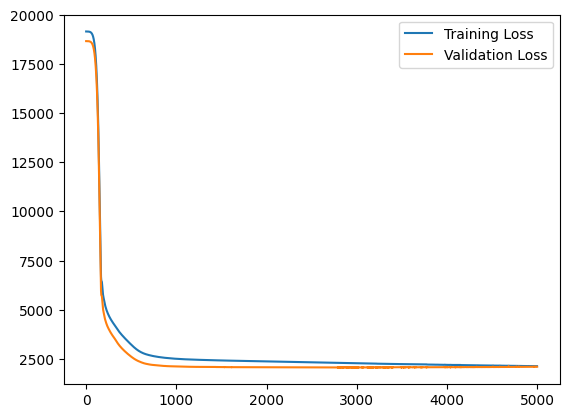

In [692]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='best')

In [693]:
df = pd.read_csv('data/test.csv')
model = torch.load('mlp_model.pth', weights_only=False)
model.eval()
256
index = df['id']
X = df.drop(['id'], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y_pred = model(X)[:, 0]

df = pd.DataFrame(y_pred.detach().numpy(), columns=['price'])
df = pd.concat([index, df], axis=1)
df.rename(columns={'price': 'answer'}, inplace=True)
df.to_csv('output.csv', index=False)

df = pd.read_csv('data/train_with_outliers.csv')
X = df.drop(['price'], axis=1)
X = torch.tensor(X.values, dtype=torch.float32)
y = df['price'].values
y_pred = model(X)[:, 0]
loss = loss_fn(y_pred, torch.tensor(y, dtype=torch.float32)).item()
print(f'Loss: {loss}')

Loss: 2752.245361328125
